In [1]:
# Código para que los resultados no se corten
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [2]:
# conditional install
try:
  from pytorch_tabnet.tab_model import TabNetClassifier
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install pytorch-tabnet

  from pytorch_tabnet.tab_model import TabNetClassifier

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.2 MB/s eta 0:00:00


In [3]:
import random
import os
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
import seaborn as sns

<IPython.core.display.Javascript object>

In [4]:
# Función para definir en un solo lugar todas las semillas
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
seed_everything(seed_value)

<IPython.core.display.Javascript object>

Leemos el archivo y seleccionamos las features

In [5]:
df = pd.read_csv('postprandial_hypoglycemias.csv')
physiological_features = ['glucose','cho','next_iob','cob','aob_3h','aob_6h']
physiological_features_no_glucose = ['cho','iob','next_iob','cob','aob_3h','aob_6h']
no_glucose_related_features = ['glucose','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob','aob_3h','aob_6h']
no_glucose_related_features_exclude_aob = ['glucose','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob']
more_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob','aob_3h','aob_6h']
more_features_exclude_aob = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob']
more_features_no_cob_no_iob = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared']
all_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared',
                'cob','next_iob','iob','aob_3h','aob_6h','hour']
selected_features = all_features
target = 'hypoglycemia'
df = df[selected_features + [target]]

df = df.dropna()
df = df.reset_index(drop=True)
X = df.drop(target, axis=1)
y = df[target]


<IPython.core.display.Javascript object>

In [6]:
print(f'Total de registros: {len(df)}')
print(f'Total de registros con hipoglicemia: {np.count_nonzero(y == 1)}')

<IPython.core.display.Javascript object>

Total de registros: 654
Total de registros con hipoglicemia: 104


In [7]:
# Implementación de la métrica para F1 score
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        return f1_score(y_true, y_pred)

<IPython.core.display.Javascript object>

In [8]:
# Implementación de la métrica para MCC
class MCC(Metric):
    def __init__(self):
        self._name = "MCC"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        if mcc_denominator == 0:
            return 0
        else:
            return mcc_numerator / mcc_denominator

<IPython.core.display.Javascript object>

# **Cross Validation**
Implementación con CV para probar hiperparámetros y selección de features

In [9]:
from sklearn.model_selection import StratifiedKFold

n_steps = 5
k_folds = 5
gamma = 1.3
patience = 50
epochs = 150
aug = ClassificationSMOTE(p=0.3)
batch_size = 64
virtual_batch_size = 8

evaluation_metrics = ['MCC','auc']

skf = StratifiedKFold(n_splits=k_folds, shuffle=True)

accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
auc_scores = []
f1_scores = []
mcc_scores = []
cms = []
all_metrics = []
all_feature_importances = []
roc_data = []

y_real = []
y_proba = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    X_test_fold = X_test_fold.values

    classes = np.unique(y_train_fold)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train_fold)
    class_weights_dict = dict(zip(classes, class_weights))

    classifier = TabNetClassifier(
                                  verbose=1,
                                  n_steps=n_steps,
                                  gamma=gamma,
                                  )

    classifier.fit(X_train_fold.values, y_train_fold.values,
                  eval_set=[(X_train_fold.values, y_train_fold.values)],
                  eval_name=['train'],
                  batch_size=batch_size,
                  virtual_batch_size=virtual_batch_size,
                  patience=patience,
                  max_epochs=epochs,
                  weights=class_weights_dict,
                  eval_metric= evaluation_metrics,
                  augmentations=aug
                  )
    y_pred_probs = classifier.predict_proba(X_test_fold)[:,1]
    y_proba.extend(y_pred_probs)
    y_real.extend(y_test_fold)

    y_pred = (y_pred_probs >= 0.5).astype(int)

    # Confussion matrix
    cm = confusion_matrix(y_test_fold, y_pred)
    cm_df = pd.DataFrame(cm,
                        index = ['Non-Hypoglycemic', 'Hypoglycemic'],
                        columns = ['Non-Hypoglycemic', 'Hypoglycemic'])
    cms.append(cm_df)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr,tpr,roc_auc))

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    report = classification_report(y_test_fold, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic'], output_dict=True)
    f1Score = report['Hypoglycemic']['f1-score']
    mcc = matthews_corrcoef(y_test_fold, y_pred)
    accuracy = accuracy_score(y_test_fold, y_pred)
    balanced_acuracy = balanced_accuracy_score(y_test_fold, y_pred)
    metrics = {
        'MCC': mcc,
        'F1 Score (Hypoglycemia class)': f1Score,
        'Balanced accuracy': balanced_acuracy,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Classification Report': report
    }

    all_metrics.append(metrics)
    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    auc_scores.append(roc_auc)
    f1_scores.append(f1Score)
    mcc_scores.append(mcc)

    print(f"Fold {fold + 1}, AUC: {roc_auc}, F1 score: {f1Score}, MCC: {mcc}")


    #Feature importances
    feature_importances = classifier.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    all_feature_importances.append(feature_importance_df)


<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03464 | train_MCC: 0.10355 | train_auc: 0.56253 |  0:00:00s
epoch 1  | loss: 0.77978 | train_MCC: -0.03039| train_auc: 0.44496 |  0:00:01s
epoch 2  | loss: 0.71171 | train_MCC: -0.00116| train_auc: 0.51325 |  0:00:02s
epoch 3  | loss: 0.66992 | train_MCC: 0.05594 | train_auc: 0.52785 |  0:00:03s
epoch 4  | loss: 0.68703 | train_MCC: 0.05343 | train_auc: 0.55208 |  0:00:03s
epoch 5  | loss: 0.67406 | train_MCC: 0.11048 | train_auc: 0.61832 |  0:00:04s
epoch 6  | loss: 0.65361 | train_MCC: 0.06511 | train_auc: 0.6216  |  0:00:05s
epoch 7  | loss: 0.64076 | train_MCC: -0.01897| train_auc: 0.54671 |  0:00:07s
epoch 8  | loss: 0.67154 | train_MCC: 0.14976 | train_auc: 0.6083  |  0:00:09s
epoch 9  | loss: 0.65833 | train_MCC: 0.17042 | train_auc: 0.65424 |  0:00:11s
epoch 10 | loss: 0.64015 | train_MCC: 0.3051  | train_auc: 0.70539 |  0:00:13s
epoch 11 | loss: 0.62341 | train_MCC: 0.26269 | train_auc: 0.65838 |  0:00:15s
epoch 12 | loss: 0.65017 | train_MCC: 0.20074 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 1, AUC: 0.7108225108225108, F1 score: 0.3548387096774194, MCC: 0.1986592632628467


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.16959 | train_MCC: 0.03494 | train_auc: 0.45082 |  0:00:00s
epoch 1  | loss: 0.79066 | train_MCC: 0.05608 | train_auc: 0.48846 |  0:00:01s
epoch 2  | loss: 0.72875 | train_MCC: -0.0236 | train_auc: 0.45422 |  0:00:02s
epoch 3  | loss: 0.69518 | train_MCC: -0.04282| train_auc: 0.4974  |  0:00:03s
epoch 4  | loss: 0.66972 | train_MCC: 0.00402 | train_auc: 0.46114 |  0:00:04s
epoch 5  | loss: 0.6927  | train_MCC: 0.00835 | train_auc: 0.4785  |  0:00:04s
epoch 6  | loss: 0.70394 | train_MCC: -0.04523| train_auc: 0.50107 |  0:00:05s
epoch 7  | loss: 0.68309 | train_MCC: 0.06737 | train_auc: 0.54482 |  0:00:06s
epoch 8  | loss: 0.66541 | train_MCC: 0.15451 | train_auc: 0.63959 |  0:00:06s
epoch 9  | loss: 0.68279 | train_MCC: 0.1859  | train_auc: 0.66698 |  0:00:07s
epoch 10 | loss: 0.68627 | train_MCC: 0.17394 | train_auc: 0.65939 |  0:00:08s
epoch 11 | loss: 0.66619 | train_MCC: 0.10418 | train_auc: 0.59042 |  0:00:08s
epoch 12 | loss: 0.67983 | train_MCC: 0.09658 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 2, AUC: 0.7865800865800865, F1 score: 0.410958904109589, MCC: 0.28339555640304376


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07029 | train_MCC: -0.00939| train_auc: 0.50037 |  0:00:00s
epoch 1  | loss: 0.76919 | train_MCC: 0.06886 | train_auc: 0.56692 |  0:00:01s
epoch 2  | loss: 0.67256 | train_MCC: 0.11751 | train_auc: 0.6388  |  0:00:02s
epoch 3  | loss: 0.65618 | train_MCC: 0.03612 | train_auc: 0.56473 |  0:00:02s
epoch 4  | loss: 0.66065 | train_MCC: 0.03233 | train_auc: 0.52558 |  0:00:03s
epoch 5  | loss: 0.69095 | train_MCC: 0.0514  | train_auc: 0.53896 |  0:00:04s
epoch 6  | loss: 0.65169 | train_MCC: 0.14547 | train_auc: 0.60627 |  0:00:04s
epoch 7  | loss: 0.6679  | train_MCC: 0.12133 | train_auc: 0.58264 |  0:00:05s
epoch 8  | loss: 0.67931 | train_MCC: 0.10509 | train_auc: 0.54614 |  0:00:06s
epoch 9  | loss: 0.65851 | train_MCC: 0.09731 | train_auc: 0.56939 |  0:00:06s
epoch 10 | loss: 0.63256 | train_MCC: 0.20549 | train_auc: 0.68486 |  0:00:07s
epoch 11 | loss: 0.65231 | train_MCC: 0.18874 | train_auc: 0.66892 |  0:00:08s
epoch 12 | loss: 0.63852 | train_MCC: 0.20598 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 3, AUC: 0.6831168831168831, F1 score: 0.39999999999999997, MCC: 0.26817169882359754


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99739 | train_MCC: -0.06539| train_auc: 0.43608 |  0:00:00s
epoch 1  | loss: 0.77907 | train_MCC: 0.07674 | train_auc: 0.59001 |  0:00:01s
epoch 2  | loss: 0.71178 | train_MCC: 0.15628 | train_auc: 0.65674 |  0:00:01s
epoch 3  | loss: 0.6959  | train_MCC: 0.09381 | train_auc: 0.57525 |  0:00:02s
epoch 4  | loss: 0.67569 | train_MCC: 0.14666 | train_auc: 0.6351  |  0:00:03s
epoch 5  | loss: 0.67663 | train_MCC: 0.17594 | train_auc: 0.65282 |  0:00:04s
epoch 6  | loss: 0.66432 | train_MCC: 0.17917 | train_auc: 0.66572 |  0:00:05s
epoch 7  | loss: 0.64498 | train_MCC: 0.24422 | train_auc: 0.64351 |  0:00:06s
epoch 8  | loss: 0.66449 | train_MCC: 0.16326 | train_auc: 0.63379 |  0:00:06s
epoch 9  | loss: 0.666   | train_MCC: 0.09744 | train_auc: 0.64184 |  0:00:07s
epoch 10 | loss: 0.66285 | train_MCC: 0.25864 | train_auc: 0.67045 |  0:00:08s
epoch 11 | loss: 0.64434 | train_MCC: 0.18728 | train_auc: 0.64644 |  0:00:08s
epoch 12 | loss: 0.63934 | train_MCC: 0.31806 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 4, AUC: 0.6688311688311688, F1 score: 0.37499999999999994, MCC: 0.22627916317095212


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06955 | train_MCC: -0.08954| train_auc: 0.47911 |  0:00:00s
epoch 1  | loss: 0.80488 | train_MCC: -0.10712| train_auc: 0.45254 |  0:00:01s
epoch 2  | loss: 0.71156 | train_MCC: 0.02604 | train_auc: 0.52327 |  0:00:02s
epoch 3  | loss: 0.67295 | train_MCC: -0.02551| train_auc: 0.41345 |  0:00:02s
epoch 4  | loss: 0.67321 | train_MCC: -0.01267| train_auc: 0.54851 |  0:00:03s
epoch 5  | loss: 0.6621  | train_MCC: 0.11578 | train_auc: 0.61848 |  0:00:04s
epoch 6  | loss: 0.67192 | train_MCC: 0.09142 | train_auc: 0.62638 |  0:00:04s
epoch 7  | loss: 0.64644 | train_MCC: 0.284   | train_auc: 0.71437 |  0:00:05s
epoch 8  | loss: 0.64207 | train_MCC: 0.28748 | train_auc: 0.71315 |  0:00:06s
epoch 9  | loss: 0.64402 | train_MCC: 0.32444 | train_auc: 0.71845 |  0:00:06s
epoch 10 | loss: 0.63416 | train_MCC: 0.36882 | train_auc: 0.69894 |  0:00:07s
epoch 11 | loss: 0.62931 | train_MCC: 0.29133 | train_auc: 0.69784 |  0:00:08s
epoch 12 | loss: 0.62582 | train_MCC: 0.27714 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 5, AUC: 0.6640909090909091, F1 score: 0.3389830508474576, MCC: 0.18609684207969418


**Métricas agregadas**

In [10]:
y_real = np.array(y_real)
y_proba = np.array(y_proba)

aggregated_threshold = 0.5

y_pred = (y_proba >= aggregated_threshold).astype(int)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

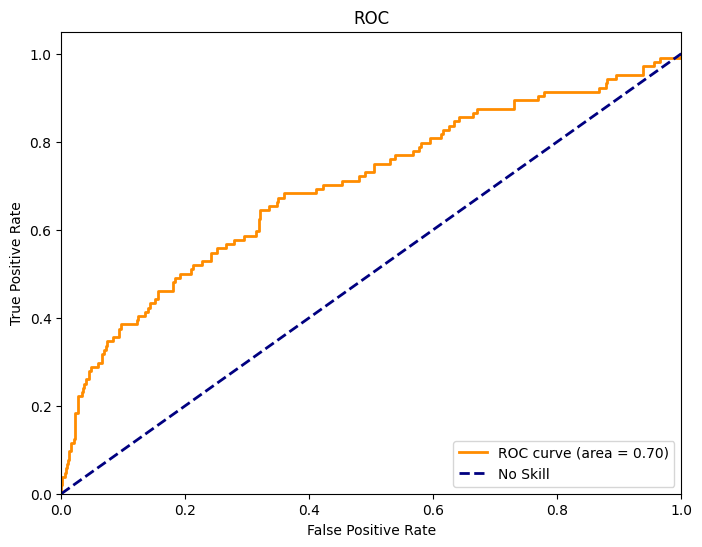

In [11]:
# Calculo curvas ROC y AUC
fpr, tpr, thresholds = roc_curve(y_real, y_proba)
roc_auc = auc(fpr, tpr)
roc_data.append((fpr,tpr,roc_auc))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>

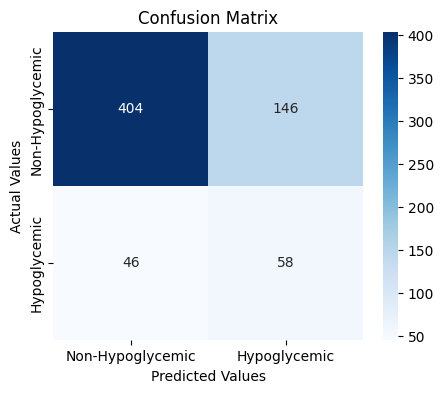

In [12]:
cm = confusion_matrix(y_real, y_pred)
cm_df = pd.DataFrame(cm,
                    index = ['Non-Hypoglycemic', 'Hypoglycemic'],
                    columns = ['Non-Hypoglycemic', 'Hypoglycemic'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [13]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
report = classification_report(y_real, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic'], output_dict=True)
f1Score = f1_score(y_real, y_pred)
mcc = matthews_corrcoef(y_real, y_pred)
accuracy = accuracy_score(y_real, y_pred)
balanced_acuracy = balanced_accuracy_score(y_real, y_pred)
metrics = {
    'MCC': mcc,
    'F1 Score' : f1Score,
    'Balanced accuracy': balanced_acuracy,
    'ROC AUC': roc_auc,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Classification Report': report
}
metrics

<IPython.core.display.Javascript object>

{'MCC': 0.23068162787171162,
 'F1 Score': 0.3766233766233766,
 'Balanced accuracy': 0.6461188811188812,
 'ROC AUC': 0.6996853146853146,
 'Accuracy': 0.7064220183486238,
 'Sensitivity': 0.5576923076923077,
 'Specificity': 0.7345454545454545,
 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.8977777777777778,
   'recall': 0.7345454545454545,
   'f1-score': 0.808,
   'support': 550},
  'Hypoglycemic': {'precision': 0.28431372549019607,
   'recall': 0.5576923076923077,
   'f1-score': 0.3766233766233766,
   'support': 104},
  'accuracy': 0.7064220183486238,
  'macro avg': {'precision': 0.5910457516339869,
   'recall': 0.6461188811188812,
   'f1-score': 0.5923116883116883,
   'support': 654},
  'weighted avg': {'precision': 0.8002238612060523,
   'recall': 0.7064220183486238,
   'f1-score': 0.7394018825211486,
   'support': 654}}}

**Métricas media**

In [14]:
# Calcular la puntuació media de todos los folds
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_sensitivity = np.mean(sensitivity_scores)
std_sensitivity = np.std(sensitivity_scores)

mean_specificity = np.mean(specificity_scores)
std_specificity = np.std(specificity_scores)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
mean_f1score = np.mean(f1_scores)
std_f1score = np.std(f1_scores)
mean_mcc = np.mean(mcc_scores)
std_mcc = np.std(f1_scores)

<IPython.core.display.Javascript object>

In [15]:
print(f"Accuracy mean: {mean_auc.round(2)}, Accuracy std: {std_auc.round(2)}")
print(f"Sensitivity mean: {mean_sensitivity.round(2)}, Sensibility std: {std_sensitivity.round(2)}")
print(f"Specificity mean: {mean_specificity.round(2)}, AUC std: {std_specificity.round(2)}")
print(f"AUC mean: {mean_auc.round(2)}, AUC std: {std_auc.round(2)}")
print(f"F1 score mean: {mean_f1score.round(2)}, F1 score std: {std_f1score.round(2)}")
print(f"MCC mean: {mean_mcc.round(2)}, MCC std: {std_mcc.round(2)}")

<IPython.core.display.Javascript object>

Accuracy mean: 0.7, Accuracy std: 0.04
Sensitivity mean: 0.56, Sensibility std: 0.08
Specificity mean: 0.73, AUC std: 0.05
AUC mean: 0.7, AUC std: 0.04
F1 score mean: 0.38, F1 score std: 0.03
MCC mean: 0.23, MCC std: 0.03


**Métricas por fold**

In [16]:
for i in range(k_folds):
    print(f"Fold {i + 1}: {all_metrics[i]}")

<IPython.core.display.Javascript object>

Fold 1: {'MCC': 0.1986592632628467, 'F1 Score (Hypoglycemia class)': 0.3548387096774194, 'Balanced accuracy': 0.6255411255411256, 'ROC AUC': 0.7108225108225108, 'Accuracy': 0.6946564885496184, 'Sensitivity': 0.5238095238095238, 'Specificity': 0.7272727272727273, 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.8888888888888888, 'recall': 0.7272727272727273, 'f1-score': 0.7999999999999999, 'support': 110}, 'Hypoglycemic': {'precision': 0.2682926829268293, 'recall': 0.5238095238095238, 'f1-score': 0.3548387096774194, 'support': 21}, 'accuracy': 0.6946564885496184, 'macro avg': {'precision': 0.5785907859078591, 'recall': 0.6255411255411256, 'f1-score': 0.5774193548387097, 'support': 131}, 'weighted avg': {'precision': 0.7894040009102381, 'recall': 0.6946564885496184, 'f1-score': 0.7286382664368382, 'support': 131}}}
Fold 2: {'MCC': 0.28339555640304376, 'F1 Score (Hypoglycemia class)': 0.410958904109589, 'Balanced accuracy': 0.688961038961039, 'ROC AUC': 0.7865800865800865, 'A

<IPython.core.display.Javascript object>

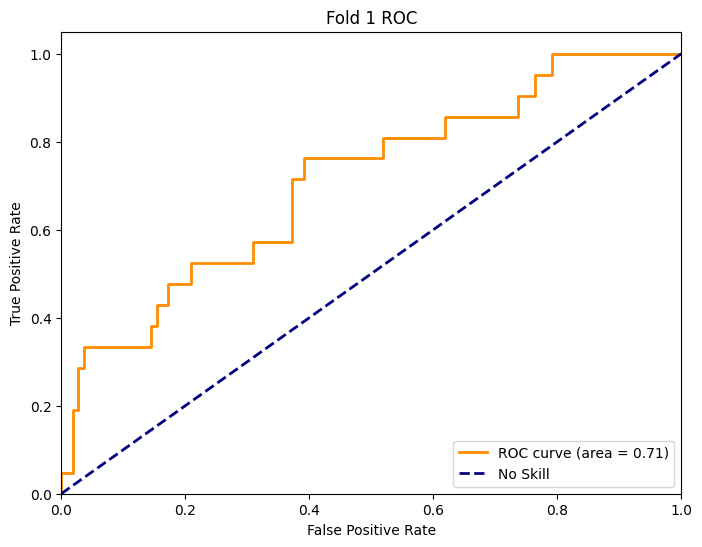

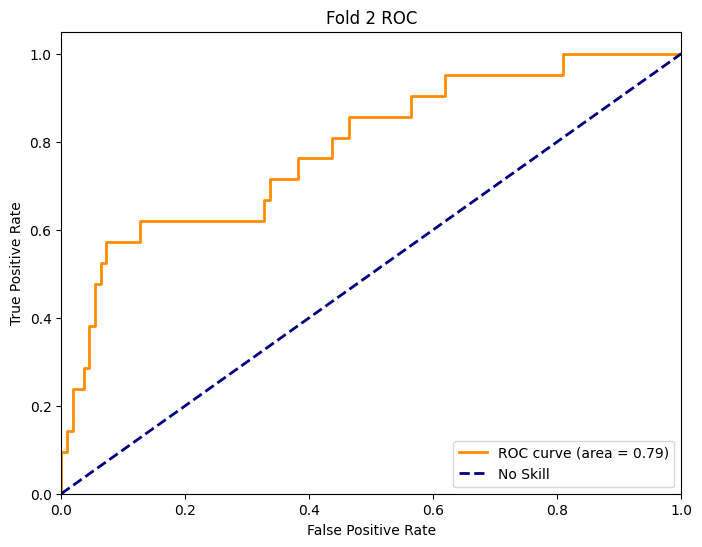

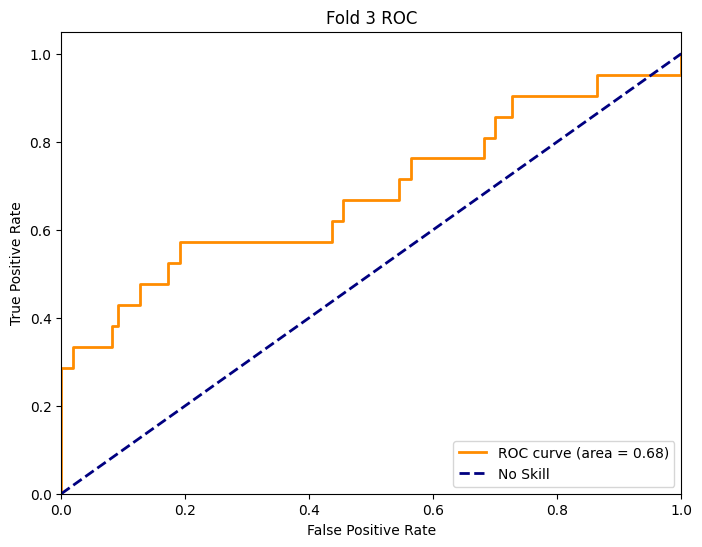

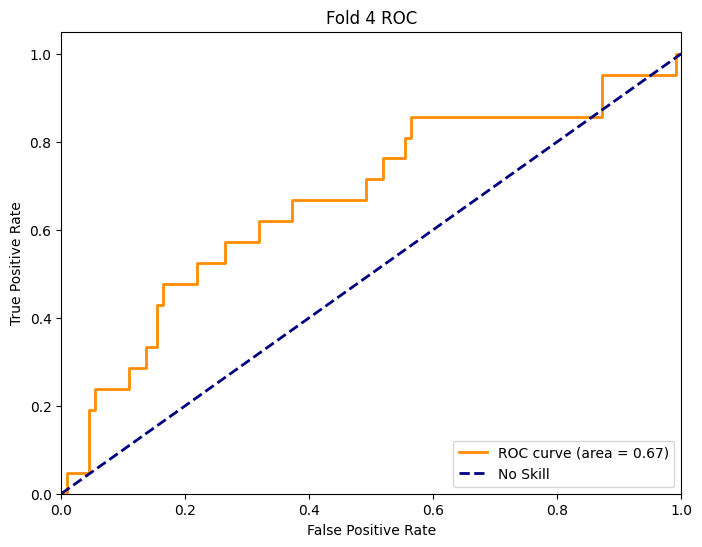

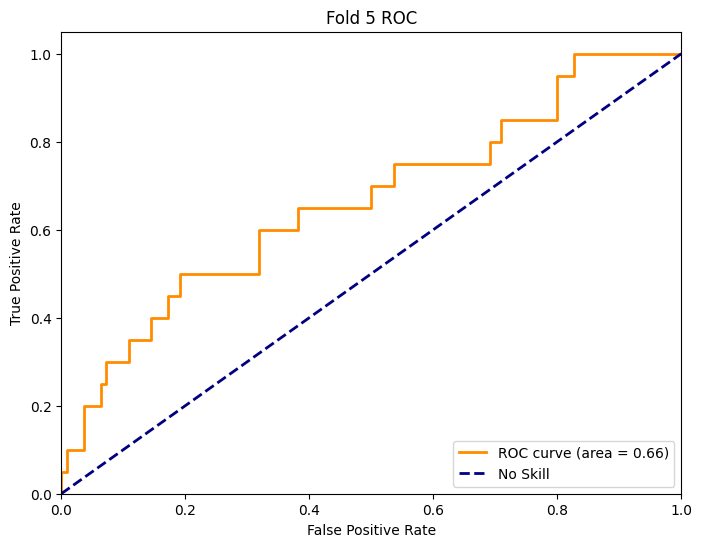

In [17]:
for i in range(k_folds):
    fpr, tpr, roc_auc = roc_data[i]
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Fold ' + str(i +1) + ' ROC')
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>

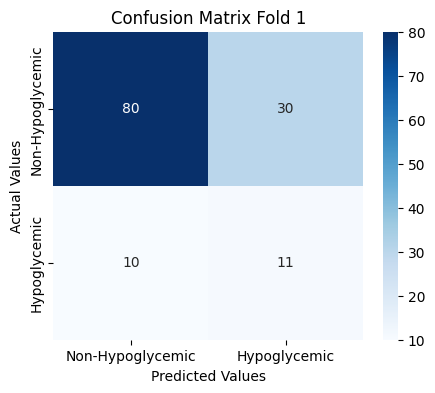

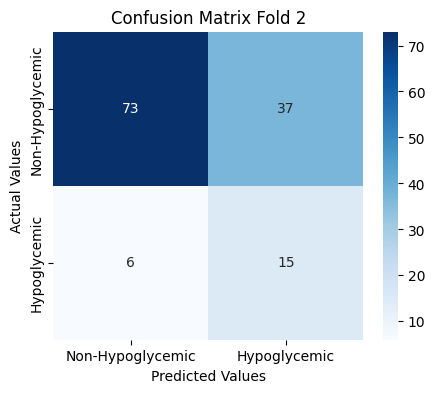

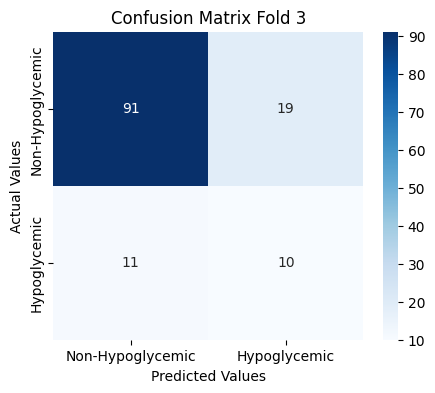

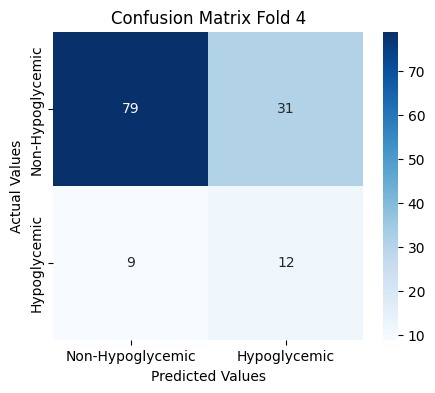

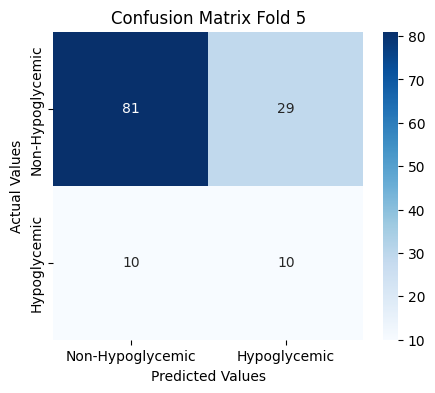

In [18]:
for i in range(k_folds):
  plt.figure(figsize=(5,4))
  sns.heatmap(cms[i], annot=True, cmap='Blues', fmt='g')
  plt.title('Confusion Matrix Fold '  + str(i + 1))
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()

Añadir mapa de calor de las features

In [19]:
for i in range(k_folds):
  print(f"Fold {i + 1}:")
  print(f"{all_feature_importances[i].to_string(index=False)}")

<IPython.core.display.Javascript object>

Fold 1:
            Feature  Importance
            glucose    0.367355
      glucose_range    0.225419
        glucose_30m    0.153792
              basal    0.077820
total_bolus_squared    0.065930
                cob    0.054860
         glucose_1h    0.016469
glucose_rate_change    0.014235
                cho    0.010800
       bolus_normal    0.010041
    mean_glucose_1h    0.003277
                iob    0.000001
           next_iob    0.000000
             aob_3h    0.000000
             aob_6h    0.000000
               hour    0.000000
Fold 2:
            Feature  Importance
                cob    0.173808
        glucose_30m    0.171747
glucose_rate_change    0.141631
           next_iob    0.133164
      glucose_range    0.109300
         glucose_1h    0.106188
total_bolus_squared    0.097307
              basal    0.029628
       bolus_normal    0.022339
             aob_3h    0.006522
             aob_6h    0.006474
    mean_glucose_1h    0.000987
                iob    0

<IPython.core.display.Javascript object>

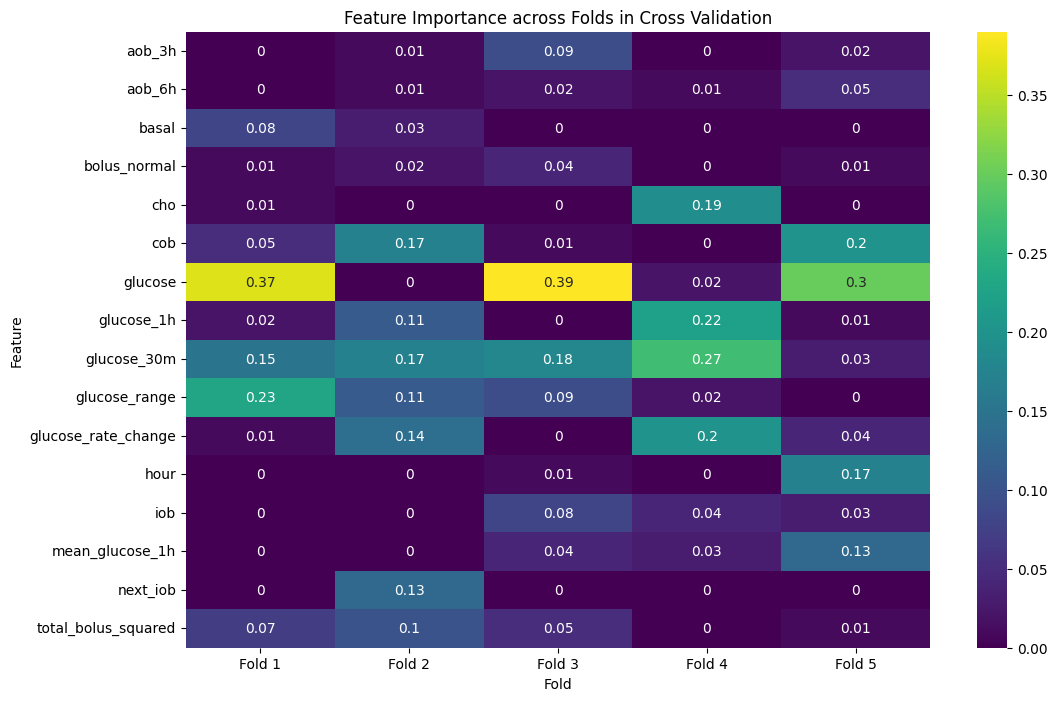

In [20]:
#Mapa de calor para representar la importancia de las características en las diferentes ejecuciones de la validación cruzada
feature_importances_combined = pd.DataFrame()

for i, df in enumerate(all_feature_importances):
    df = df.rename(columns={"Importance": f"Fold {i+1}"})
    if df.index.name != 'Feature':
        df = df.set_index('Feature')
    df = df.round(2)
    feature_importances_combined = feature_importances_combined.join(df, how="outer")

feature_importances_combined = feature_importances_combined.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(feature_importances_combined, annot=True, cmap="viridis")
plt.title("Feature Importance across Folds in Cross Validation")
plt.ylabel("Feature")
plt.xlabel("Fold")
plt.show()